# Perf stat analysis

In [10]:
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict
import seaborn as sns

#### Global variables

In [11]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

PERF_STAT_RESULTS_EXTENSION = ".txt"

def get_result_dir_path(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

def in_result_dir(path: str):
    return os.path.join(RESULTS_DIR_PATH, path)

def get_absolute_result_dir_path(result_dir_name) :
    return os.path.join(ABSOLUTE_RESULTS_DIR_PATH, result_dir_name)

#### Visualization params

In [12]:
nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = 10 # 10
min_figure_width = 40
figure_width_coeff = 0.3

line_width = 1.0

In [13]:
def init_runs_plot():
    # plt.figure(figsize=(fig_width, 5))
    # plt.legend(loc="upper left")
    plt.xlabel("Nth run")
    plt.ylabel("Run time (seconds)")
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    # ax = plt.gca()
    # ax.ticklabel_format(axis="x", useOffset=1.0)

def plot_runs(values: List[float], label = None, color = None, init_plot = True) :
    if init_plot:
        init_runs_plot()
    plt.plot(range(len(values)), values, label=label, color=color, linewidth=line_width)
    
    current_xticks_count = len(plt.xticks()[0])
    if len(values) > current_xticks_count :
        plt.xticks(range(len(values)), rotation=45)
        plt.xlim(-1, len(values))
        
    # candidate_ylim_max = max(values) * 1.2
    # if candidate_ylim_max > plt.ylim()[1] :
    #     plt.ylim(0, candidate_ylim_max)
        
    fig = plt.gcf()
    candidate_width = max(int(len(values) * figure_width_coeff), min_figure_width)
    curr_width = fig.get_size_inches()[0]
    if candidate_width > curr_width :
        fig.set_size_inches(candidate_width, figure_height)
    
    if label :
        plt.legend(loc="upper left")

In [31]:
def parse_per_cpu_result_file(file_path) -> Tuple[pd.DataFrame, Dict]:
    with open(file_path, 'r') as file:
        text = file.read()
    nas_time_match = re.search(r'Time in seconds\s+=\s+(\d*.\d*)', text)
    if nas_time_match :
        nas_time = float(nas_time_match.group(1))
        
    json_begin_pos = text.find('{')
    json_end_pos = text.rfind('}')
    json_text = text[json_begin_pos:json_end_pos + 1]
    json_lines = json_text.split('\n')
    
    events_df = pd.DataFrame()
    
    meta_values = {"nas_runtime": nas_time}
    
    event_counters: Dict[str, list] = defaultdict(list)
    for line in json_lines :
        json_object = json.loads(line)
        event_str = json_object["event"].strip()
        if event_str in ["duration_time", "user_time", "system_time"] :
            meta_values[event_str] = float(json_object["counter-value"])
        else :
            event_counters[event_str].append((int(json_object["cpu"]), float(json_object["counter-value"])))
    
    events_df = pd.DataFrame({event: [e[1] for e in sorted(values)] for event, values in event_counters.items()})
    if "LLC-load-misses" in events_df and "LLC-store-misses" in events_df and "LLC-loads" in events_df and "LLC-stores" in events_df:
        events_df["LLC-all-misses"] = events_df["LLC-load-misses"] + events_df["LLC-store-misses"]
        events_df["LLC-load-misses-ratio"] = events_df["LLC-load-misses"] / events_df["LLC-loads"]
        events_df["LLC-store-misses-ratio"] = events_df["LLC-store-misses"] / events_df["LLC-stores"]
    
    events_df["ml_l3_mr.all"] = events_df["mem_load_l3_miss_retired.remote_dram"] + events_df["mem_load_l3_miss_retired.local_dram"]
    # events_df["mem_load_l3_miss_retired-over-LLC-all"] = events_df["ml_l3_mr.all"] / events_df["LLC-all-misses"]
    events_df["ml_l3_mr.remote_over_local_dram"] = events_df["mem_load_l3_miss_retired.remote_dram"] / events_df["mem_load_l3_miss_retired.local_dram"]
    events_df["ml_l3_mr.remote_over_total"] = events_df["mem_load_l3_miss_retired.remote_dram"] / events_df["ml_l3_mr.all"]
    events_df["ml_l3_mr.local_over_total"] = events_df["mem_load_l3_miss_retired.local_dram"] / events_df["ml_l3_mr.all"]
    
    # mem_load_l3_miss_retired.remote_fwd
    # mem_load_l3_miss_retired.remote_hitms
    events_df["ml_l3_mr.fwd_over_total"] = events_df["mem_load_l3_miss_retired.remote_fwd"] / events_df["ml_l3_mr.all"]
    events_df["ml_l3_mr.hitm_over_total"] = events_df["mem_load_l3_miss_retired.remote_hitm"] / events_df["ml_l3_mr.all"]
    return events_df, meta_values
    

# TODO Add posibility to specify events ?
def parse_batch_results(dir_path) :
    file_paths = [os.path.join(dir_path, file) for file in os.listdir(dir_path) if file.endswith(PERF_STAT_RESULTS_EXTENSION)]
    concatenated_dict = defaultdict(list)
    for file_path in file_paths :
        events_df, meta_values = parse_per_cpu_result_file(file_path)
        for series_name, series in events_df.items() :
            concatenated_dict[f"min:{series_name}"].append(series.min())
            concatenated_dict[f"max:{series_name}"].append(series.max())
            concatenated_dict[f"sum:{series_name}"].append(series.sum())
            concatenated_dict[f"avg:{series_name}"].append(series.sum() / len(series))
        for key, val in meta_values.items() :
            concatenated_dict[key].append(val)
    return pd.DataFrame(concatenated_dict)



# TODO Maybe return the number of CPUs so that we can compute the average when we have only the sum ?
def parse_batches_results_from_benchmark(benchmark_dir_path: str) -> List[pd.DataFrame] :
    dfs = {}
    contents = os.listdir(benchmark_dir_path)
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        print(f"Parsing batch in directory {dir_path}")
        dfs[c] = parse_batch_results(dir_path)
    return dfs


def combine_benchmark_dir(benchmark_dir_name) :
    df = pd.DataFrame()
    benchmark_dir_path = get_result_dir_path("_perf/" + benchmark_dir_name)
    contents = os.listdir(benchmark_dir_path)
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        
        df = pd.concat([df, parse_batch_results(dir_path)], ignore_index=True)
    return df


In [28]:
def plot_event_from_benchmark(all_dfs: Dict[str, pd.DataFrame], aggregated_event: str, variations_only = False) :
    plotting_df = pd.DataFrame({dir: df[aggregated_event] for dir, df in all_dfs.items()})
    means = plotting_df.mean().sort_values()
    sorted_plotting_df = plotting_df[means.index]
    
    if variations_only :
        reference_value = min(means)
        for col in sorted_plotting_df :
            sorted_plotting_df[col] = ((sorted_plotting_df[col] - reference_value) * 100) / reference_value
            
    plt.ylabel("Event value")
    sns.violinplot(data = sorted_plotting_df, inner_kws=dict(box_width=15, whis_width=7, color=".3"))

    plt.gcf().set_size_inches(28, 18)
    plt.xticks(rotation=20, ha='right')
    plt.minorticks_on()
    plt.grid(axis="y", which="major", color='0.2', linestyle='-', linewidth=0.5)
    plt.grid(axis="y", which="minor", color='0.1', linestyle=':', linewidth=0.5)
    plt.scatter(x=range(len(means)),y=means, marker='o', s=30, c="white", alpha=1, zorder=10)
    # plt.grid(axis="x", which="major")
    plt.ylim(bottom=0.0)
    plt.title(aggregated_event)
    plt.show()
    

In [29]:
all_dfs = parse_batches_results_from_benchmark(in_result_dir("_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20"))

Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-none
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-sequential
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-sockorder


dict_keys(['nb-disabled-none', 'nb-disabled-sequential', 'nb-disabled-sockorder'])


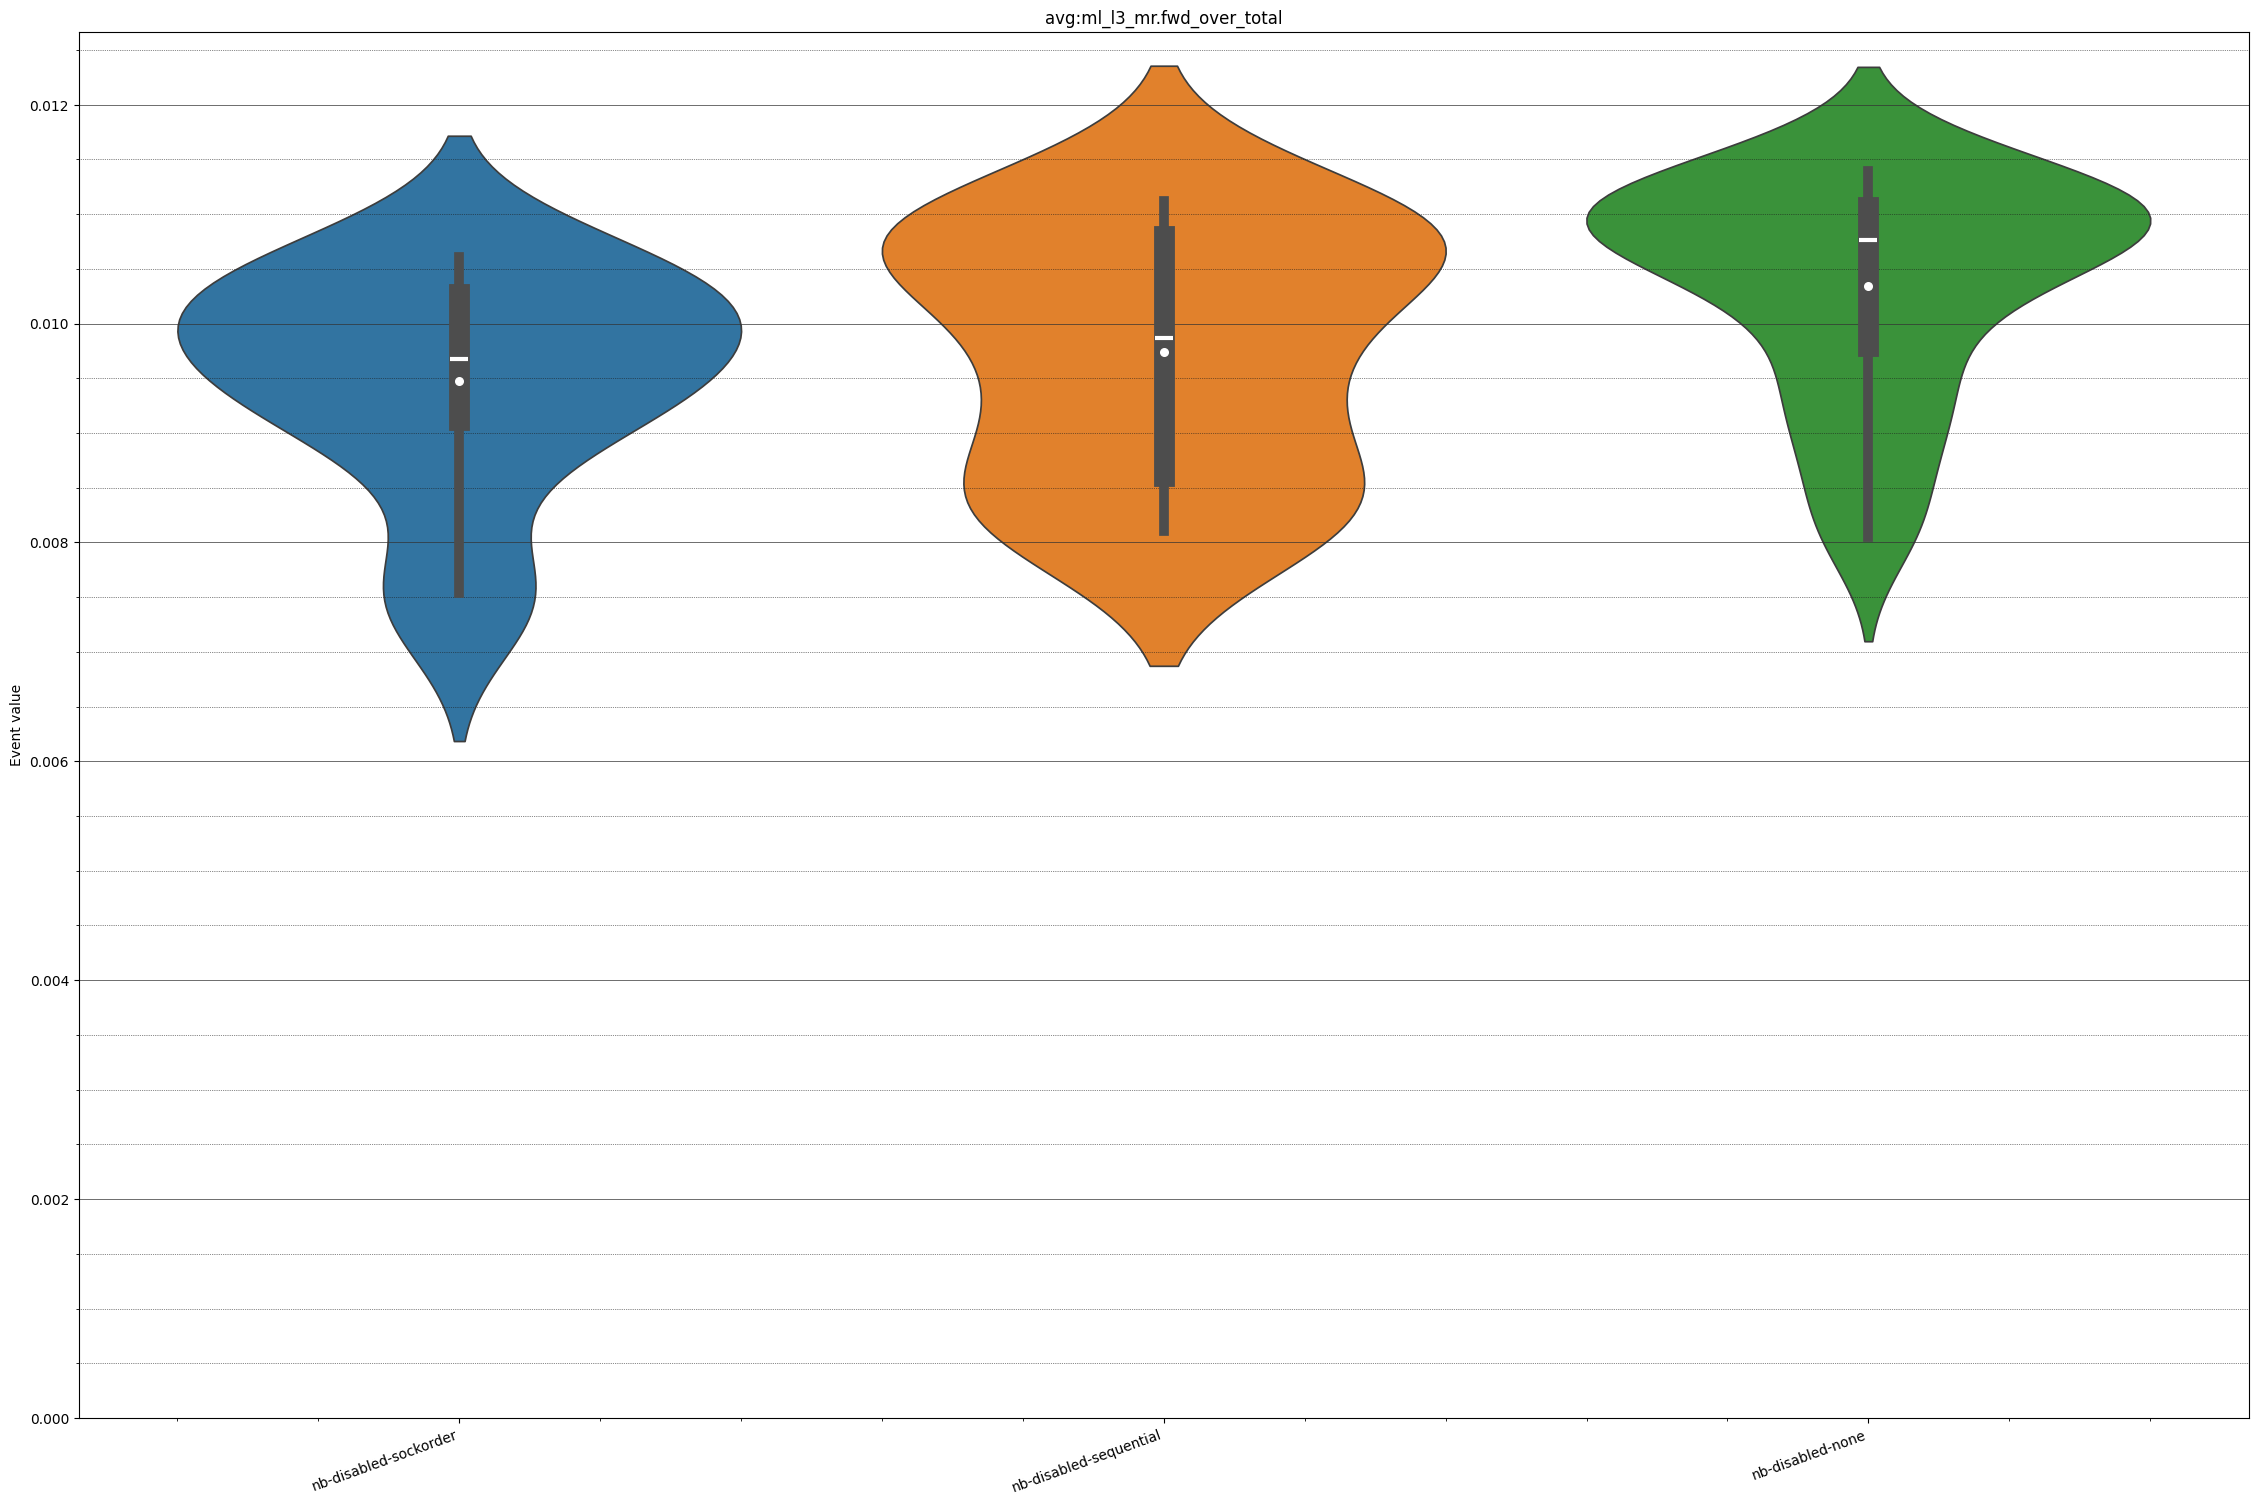

In [30]:
print(all_dfs.keys())
all_dfs["nb-disabled-none"]
plot_event_from_benchmark(all_dfs, "avg:ml_l3_mr.fwd_over_total", False)

In [1]:
plot_event_from_benchmark(all_dfs, "avg:mem_load_l3_miss_retired.remote_over_total")
plot_event_from_benchmark(all_dfs, "nas_runtime")

list(all_dfs.values())[0].columns

NameError: name 'plot_event_from_benchmark' is not defined

### Focus on L3 miss categories

In [70]:
def print_correlations(df: pd.DataFrame, target_column = "nas_runtime"):
    # We first remove all the avg columns if any because will give the same result as sum
    
    avg_columns = [col for col in df.columns if "avg:" in col]
    df = df.drop(avg_columns, axis=1)
    pd.set_option('display.max_rows', 500)
    correlation_df = df.corr()
    correlation_series = correlation_df[target_column].drop(target_column).sort_values(ascending=False, key=abs)

    threshold = 0.98
    previous = []
    for col in correlation_series.index:
        was_dropped = False
        for previous_col in previous:
            # print(correlation_df.loc[col, previous_col])
            if correlation_df.loc[col, previous_col] > threshold:
                # print(f"Found correlation > {threshold} between {col} and {previous_col}")
                correlation_series.drop(col, inplace=True)
                was_dropped = True
                break
        if not was_dropped and "time" not in col:
            previous.append(col)
            
    display(correlation_series)
    # new_df = correlations.to_frame(name = "corr")
    # new_df["abs_corr"] = new_df["corr"].map(lambda x : abs(x))
    # new_df.sort_values(by = "abs_corr", ascending=False)
    # display(correlations.sort_values(ascending=False, key=abs))
    
    
# First within each batch, and then as a whole



In [71]:
test_dfs = parse_batches_results_from_benchmark(in_result_dir("_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20"))
concatenated = pd.concat(test_dfs.values())
print_correlations(concatenated)

Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-none
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-sequential
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-sockorder


duration_time                               0.999983
user_time                                   0.999976
sum:ml_l3_mr.local_over_total              -0.987359
sum:ml_l3_mr.remote_over_total              0.987359
sum:mem_load_l3_miss_retired.local_dram    -0.982023
sum:mem_load_l3_miss_retired.remote_hitm   -0.956419
max:mem_load_l3_miss_retired.remote_hitm   -0.935753
max:mem_load_l3_miss_retired.remote_dram    0.930707
sum:ml_l3_mr.all                           -0.756413
max:ml_l3_mr.hitm_over_total               -0.742151
min:ml_l3_mr.hitm_over_total                0.706117
min:ml_l3_mr.all                           -0.643007
max:mem_load_l3_miss_retired.local_dram    -0.569269
max:ml_l3_mr.fwd_over_total                 0.535965
min:mem_load_l3_miss_retired.remote_hitm    0.482274
max:ml_l3_mr.all                           -0.472977
min:mem_load_l3_miss_retired.remote_dram    0.376699
max:ml_l3_mr.local_over_total              -0.374187
sum:ml_l3_mr.hitm_over_total                0.

In [72]:
print_correlations(concatenated, target_column="duration_time")

user_time                                   0.999986
nas_runtime                                 0.999983
sum:ml_l3_mr.local_over_total              -0.987873
sum:ml_l3_mr.remote_over_total              0.987873
sum:mem_load_l3_miss_retired.local_dram    -0.982095
sum:mem_load_l3_miss_retired.remote_hitm   -0.957160
max:mem_load_l3_miss_retired.remote_hitm   -0.935755
max:mem_load_l3_miss_retired.remote_dram    0.931592
sum:ml_l3_mr.all                           -0.755298
max:ml_l3_mr.hitm_over_total               -0.742851
min:ml_l3_mr.hitm_over_total                0.705345
min:ml_l3_mr.all                           -0.642081
max:mem_load_l3_miss_retired.local_dram    -0.568975
max:ml_l3_mr.fwd_over_total                 0.535045
min:mem_load_l3_miss_retired.remote_hitm    0.481368
max:ml_l3_mr.all                           -0.471479
min:mem_load_l3_miss_retired.remote_dram    0.377754
max:ml_l3_mr.local_over_total              -0.375178
sum:ml_l3_mr.hitm_over_total                0.

In [51]:
test_dfs = parse_batches_results_from_benchmark(in_result_dir("_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20"))
concatenated = pd.concat(test_dfs.values())
test_series = concatenated.corr()["nas_runtime"].drop("nas_runtime").sort_values(ascending=False, key=abs)
# print(test_series
# print_correlations(concatenated)
test_series

Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-none
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-sequential
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-sockorder


duration_time                               0.999983
user_time                                   0.999976
avg:ml_l3_mr.local_over_total              -0.987359
sum:ml_l3_mr.local_over_total              -0.987359
sum:ml_l3_mr.remote_over_total              0.987359
avg:ml_l3_mr.remote_over_total              0.987359
avg:ml_l3_mr.remote_over_local_dram         0.985466
sum:ml_l3_mr.remote_over_local_dram         0.985466
sum:mem_load_l3_miss_retired.local_dram    -0.982023
avg:mem_load_l3_miss_retired.local_dram    -0.982023
sum:mem_load_l3_miss_retired.remote_dram    0.979381
avg:mem_load_l3_miss_retired.remote_dram    0.979381
min:ml_l3_mr.local_over_total              -0.976917
max:ml_l3_mr.remote_over_total              0.976917
max:ml_l3_mr.remote_over_local_dram         0.969410
min:mem_load_l3_miss_retired.local_dram    -0.968579
sum:mem_load_l3_miss_retired.remote_hitm   -0.956419
avg:mem_load_l3_miss_retired.remote_hitm   -0.956419
max:mem_load_l3_miss_retired.remote_hitm   -0.

In [44]:
def find_high_correlation_pairs(df, threshold=0.9):
    """
    Find and print pairs of columns in a DataFrame that have a correlation above a certain threshold.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    threshold (float): The correlation threshold.
    """
    correlation_matrix = df.corr()
    high_corr_pairs = []
    
    for col1 in correlation_matrix.columns:
        for col2 in correlation_matrix.columns:
            if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold:
                pair = tuple(sorted((col1, col2)))
                if pair not in high_corr_pairs:
                    high_corr_pairs.append(pair)
                    print(f"Pair: {pair}, Correlation: {correlation_matrix.loc[col1, col2]}")

find_high_correlation_pairs(concatenated)

Pair: ('min:mem_load_l3_miss_retired.local_dram', 'sum:mem_load_l3_miss_retired.local_dram'), Correlation: 0.9844750424875752
Pair: ('avg:mem_load_l3_miss_retired.local_dram', 'min:mem_load_l3_miss_retired.local_dram'), Correlation: 0.9844750424875752
Pair: ('min:mem_load_l3_miss_retired.local_dram', 'sum:mem_load_l3_miss_retired.remote_dram'), Correlation: -0.947035876671592
Pair: ('avg:mem_load_l3_miss_retired.remote_dram', 'min:mem_load_l3_miss_retired.local_dram'), Correlation: -0.947035876671592
Pair: ('max:mem_load_l3_miss_retired.remote_hitm', 'min:mem_load_l3_miss_retired.local_dram'), Correlation: 0.920544977305032
Pair: ('min:mem_load_l3_miss_retired.local_dram', 'sum:mem_load_l3_miss_retired.remote_hitm'), Correlation: 0.9156138960713638
Pair: ('avg:mem_load_l3_miss_retired.remote_hitm', 'min:mem_load_l3_miss_retired.local_dram'), Correlation: 0.9156138960713638
Pair: ('max:ml_l3_mr.remote_over_local_dram', 'min:mem_load_l3_miss_retired.local_dram'), Correlation: -0.94207181

TODOs :
- Try and focus on the worst core instead of showing an average across all cores